<hr>
<h1><b>Coursework 1:</b></h1>
<h3><i>Submitted for the partial fulfilment of the DSM010 course</i></h3>
<h3><i>By Hendrik Matthys van Rooyen</i></h3>
<h3><i>230221176</i></h3>

<hr>

# **Big data Analysis with Hadoop**

---

## Introduction

This report presents a comprehensive analysis conducted as part of the DSM010 Big Data Analysis coursework.

The analysis includes the following tasks:

1. **Descriptive Statistics**: Calculating daily descriptive statistics for wind speed and dry bulb temperature across multiple weather stations.
2. **Linear Regression Analysis**: Developing MapReduce jobs to perform linear regression on selected weather variables, calculating the coefficients of the resulting model.
3. **K-Means Clustering**: Implementing the K-Means clustering algorithm using Euclidean, Manhattan, and Cosine distance measures to determine the optimal number of clusters and evaluate their performance.
4. **Classification Using OpenClip**: Using a classifier to distinguish between images of cats and dogs, demonstrating the application of machine learning models within a Hadoop environment.

Each section of this report details the methodologies used, the results obtained, and an analysis of the findings. This structured approach ensures that the data is thoroughly examined, providing insights into the patterns and trends within the dataset. The report concludes with a summary of the optimal configurations and the implications of the results for future data analysis projects.

## Instructions

The project executable has been built specifically in order to be able to execute the project from your local machine. This can be done by running the `run.bat` file, however, a few dependencies need to be sorted first,

1. In order to hide the server credentials from general users, such as those that may have access to a public git repo the credentials is stored in a `config.txt` file, in the same folder location as that of the `run.bat`, upon the first execution of the `run.bat` this file should be created automatically. Ensure that the credentials to your ssh server is placed filled in here, these include Username, Hostname, PrivateKeyPath.

2. In order to be able to execute everything without authentication requests from the server a RSA key-pair is utilized. Open a terminal on your local machine and generate an RSA key pair, copy the public key to the SSH, and verify that the key-based authentication works by logging. It may be necessary to modify the access permissions for the private key. 

3. Once the key is functioning and the config.txt is ready you can execute the `run.bat`.

Note that the `run.bat` file executes a "runner" for environment setup and then also for the process required for each question based on their individual requirements.
To execute only one part at a time you can comment out the others that is not needed, however it is recommended to setup the environment at least once, ut preferably before each execution.

Each runner is responsible for executing the mappers or reducers in the hadoop environment, or alternatively the mahout commands on the ssh environment.
The runners also collects the output of each process and transfers them to the local environment after execution.

---

## Helper Functions

In [1]:
import pandas as pd

In [4]:
def display_tsv_as_table(file_path):
    # Read the TSV file
    df = pd.read_csv(file_path, sep='\t')
    return df

In [10]:
def read_and_print_file(file_path):
    try:
        with open(file_path, 'r', encoding='utf-8') as file:
            contents = file.read()
            print(contents)
    except Exception as e:
        print(f"An error occurred while reading the file: {e}")

In [73]:
import os
import xml.etree.ElementTree as ET
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Function to calculate the Within-Cluster Sum of Squares (WCSS) from a given XML file
def calculate_wcss(file_path):
    # Parse the XML file
    tree = ET.parse(file_path)
    root = tree.getroot()
    namespaces = {'graphml': 'http://graphml.graphdrawing.org/xmlns'}  # Define namespaces for parsing

    clusters = {}  # Dictionary to hold cluster data

    # Loop through each edge in the XML file and extract cluster information
    for edge in root.findall('.//graphml:edge', namespaces):
        cluster_name = edge.get('source')
        value = edge.find('graphml:data[@key="weight"]', namespaces).text
        value = float(value)  # Convert value to float
        if np.isnan(value): value = 0  # Handle NaN values

        # Add value to the corresponding cluster
        if cluster_name not in clusters:
            clusters[cluster_name] = []
        clusters[cluster_name].append(value)
    
    # Calculate the sum, count, and average for each cluster
    cluster_sums = {cluster: sum(values) for cluster, values in clusters.items()}
    cluster_counts = {cluster: len(values) for cluster, values in clusters.items()}
    cluster_averages = {cluster: cluster_sums[cluster] / cluster_counts[cluster] for cluster in clusters}

    # Calculate the overall average
    overall_average = sum(cluster_averages.values()) / len(cluster_averages)
    return overall_average

# Function to extract metrics from a text file
def extract_metrics(file_path):
    metrics = {}  # Dictionary to hold extracted metrics

    # Read the file line by line and extract relevant metrics
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith("Inter-Cluster Density:"):
                metrics['Inter-Cluster Density'] = float(line.split(":")[1].strip())
            elif line.startswith("Intra-Cluster Density:"):
                metrics['Intra-Cluster Density'] = float(line.split(":")[1].strip())
            elif line.startswith("CDbw Inter-Cluster Density:"):
                metrics['CDbw Inter-Cluster Density'] = float(line.split(":")[1].strip())
            elif line.startswith("CDbw Intra-Cluster Density:"):
                metrics['CDbw Intra-Cluster Density'] = float(line.split(":")[1].strip())
            elif line.startswith("CDbw Separation:"):
                metrics['CDbw Separation'] = float(line.split(":")[1].strip())
    
    return metrics

# Function to interpolate NaN values in a list of values
def interpolate_nan(values):
    for i in range(len(values)):
        if np.isnan(values[i]):
            prev_value = values[i - 1] if i - 1 >= 0 else 0
            next_value = values[i + 1] if i + 1 < len(values) else 0
            values[i] = (prev_value + next_value) / 2  # Interpolate by averaging adjacent values
    return values

# Function to process all files in a folder and extract k values and corresponding metrics
def process_folder(folder_path):
    k_wcss_pairs = []  # List to hold k values and WCSS pairs
    metrics_data = {key: [] for key in ['k', 'Inter-Cluster Density', 'Intra-Cluster Density', 'CDbw Inter-Cluster Density', 'CDbw Intra-Cluster Density', 'CDbw Separation']}
    
    # Loop through each file in the folder and process it
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        k_value = int(file_name.replace('k', ''))  # Extract k value from file name
        wcss = calculate_wcss(file_path)  # Calculate WCSS
        metrics = extract_metrics(file_path)  # Extract other metrics
        
        # Append k value and metrics to the corresponding lists
        metrics_data['k'].append(k_value)
        metrics_data['Inter-Cluster Density'].append(metrics.get('Inter-Cluster Density', np.nan))
        metrics_data['Intra-Cluster Density'].append(metrics.get('Intra-Cluster Density', np.nan))
        metrics_data['CDbw Inter-Cluster Density'].append(metrics.get('CDbw Inter-Cluster Density', np.nan))
        metrics_data['CDbw Intra-Cluster Density'].append(metrics.get('CDbw Intra-Cluster Density', np.nan))
        metrics_data['CDbw Separation'].append(metrics.get('CDbw Separation', np.nan))
        
        k_wcss_pairs.append((k_value, wcss))
    
    # Sort the k_wcss_pairs by k value
    k_wcss_pairs.sort(key=lambda x: x[0])
    k_values, wcss_values = zip(*k_wcss_pairs)
    
    # Sort the metrics_data dictionary by k values
    sorted_indices = sorted(range(len(metrics_data['k'])), key=lambda i: metrics_data['k'][i])
    for key in metrics_data:
        metrics_data[key] = [metrics_data[key][i] for i in sorted_indices]
    
    # Interpolate NaN values in the metrics data
    for key in metrics_data:
        if key != 'k':
            metrics_data[key] = interpolate_nan(metrics_data[key])
    
    return list(k_values), list(wcss_values), pd.DataFrame(metrics_data)

# Function to smooth values using a moving average
def smooth_values(values, window_size=3):
    smoothed_values = np.convolve(values, np.ones(window_size)/window_size, mode='valid')
    return smoothed_values

# Function to plot metrics in a grid
def plot_metrics_grid(k_values, wcss_values, metrics_data, overall_title):
    metrics = ['Inter-Cluster Density', 'Intra-Cluster Density', 'CDbw Inter-Cluster Density', 'CDbw Intra-Cluster Density', 'CDbw Separation']
    
    # Plotting in a grid of 2 columns and 3 rows
    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle(overall_title, fontsize=16)
    
    # Plot WCSS
    axs[0, 0].plot(k_values, wcss_values, 'bo-', label='Original WCSS')
    smoothed_wcss_values = smooth_values(wcss_values)
    axs[0, 0].plot(k_values[len(k_values) - len(smoothed_wcss_values):], smoothed_wcss_values, 'r-', label='Smoothed WCSS')
    axs[0, 0].set_xlabel('Number of Clusters (k)')
    axs[0, 0].set_ylabel('WCSS')
    axs[0, 0].set_title('WCSS vs Number of Clusters (k)')
    axs[0, 0].grid(True)
    axs[0, 0].legend()
    
    # Plot each metric
    for i, metric in enumerate(metrics):
        row = (i + 1) // 2
        col = (i + 1) % 2
        values = metrics_data[metric]
        axs[row, col].plot(k_values, values, 'bo-', label=f'Original {metric}')
        smoothed_values = smooth_values(values)
        axs[row, col].plot(k_values[len(k_values) - len(smoothed_values):], smoothed_values, 'r-', label=f'Smoothed {metric}')
        axs[row, col].set_xlabel('Number of Clusters (k)')
        axs[row, col].set_ylabel(metric)
        axs[row, col].set_title(f'{metric} vs Number of Clusters (k)')
        axs[row, col].grid(True)
        axs[row, col].legend()
    
    plt.tight_layout()
    plt.show()

---

## Question 1

**Find the descriptive statistics for temperature of each day of a given month for the year 2007**

### Task 1

*Difference between the maximum and the minimum “Wind Speed” from all weather stations for each day in the month*

#### Mapper:
1. Reads each line from standard input.
2. Strips any leading or trailing whitespace.
3. Splits the line into fields using commas.
4. Extracts the date and wind speed fields.
5. Tries to convert the wind speed to a float to ensure it is a valid number. If it is not, it skips to the next line.
6. If the wind speed is valid, it prints the date and wind speed separated by a tab.

```python
#! /usr/bin/env python3


import sys

for line in sys.stdin:
    line = line.strip()
    fields = line.split(',')
    date = fields[1].strip()
    wind_speed = fields[12].strip()

    try: 
        float(wind_speed)
    except ValueError:
        continue
    else:
        print(f"{date}\t{wind_speed}")
```

#### Reducer:
1. Initializes variables to keep track of the current date, minimum speed, and maximum speed.
2. Prints the header for the output.
3. Reads each line from standard input.
4. Strips any leading or trailing whitespace.
5. Splits the line into date and speed based on the tab.
6. Converts the speed to an integer.
7. If the date has changed from the previous date:
   - If this is not the first date, it prints the current date, max speed, min speed, and the difference between max and min speed.
   - Resets the current date, min speed, and max speed to the new date and speed.
8. If the date is the same as the current date:
   - Updates the min and max speeds if the current speed is lower or higher, respectively.
9. After processing all lines, it prints the final date, max speed, min speed, and the difference.

```python
#! /usr/bin/env python3

import sys

current_date = None
min_speed = None
max_speed = None

print(f"Date\tMax Speed\tMin Speed\tSpeed Difference")
for line in sys.stdin:
    line = line.strip()
    date, speed = line.split('\t')
    speed = int(speed)

    if current_date != date:
        if current_date is not None:
            # Output the difference for the previous date
            print(f"{current_date}\t{max_speed}\t{min_speed}\t{max_speed - min_speed}")
        # Reset for new date
        current_date = date
        min_speed = speed
        max_speed = speed
    else:
        # Update min and max
        if speed < min_speed:
            min_speed = speed
        if speed > max_speed:
            max_speed = speed

# Output the difference for the last processed date
if current_date is not None:
    print(f"{current_date}\t{max_speed}\t{min_speed}\t{max_speed - min_speed}")
```

In [6]:
display_tsv_as_table('Question1/outputs/output1/part-00000')

,Date,Max Speed,Min Speed,Speed Difference
0,20070401,43,0,43
1,20070402,56,0,56
2,20070403,40,0,40
3,20070404,96,0,96
4,20070405,42,0,42
5,20070406,41,0,41
6,20070407,43,0,43
7,20070408,64,0,64
8,20070409,71,0,71
9,20070410,57,0,57


### Task 2

*Daily maximum and minimum “Dry Bulb Temp” across all weather stations.*

#### Mapper:

1. Reads each line from standard input.
2. Strips any leading or trailing whitespace.
3. Splits the line into fields using commas.
4. Extracts the date and dry bulb temperature fields.
5. Tries to convert the dry bulb temperature to a float to ensure it is a valid number. If it is not, it skips to the next line.
6. If the dry bulb temperature is valid, it prints the date and dry bulb temperature separated by a tab.

```python
#!/usr/bin/env python3

import sys

for line in sys.stdin:
    line = line.strip()
    fields = line.split(',')
    date = fields[1].strip()
    dry_bulb_temp = fields[8].strip()
    
    try: 
        float(dry_bulb_temp)
    except ValueError:
        continue
    else:
        print(f"{date}\t{dry_bulb_temp}")
```

#### Reducer:

1. Initializes variables to keep track of the current date, minimum temperature, and maximum temperature.
2. Prints the header for the output.
3. Reads each line from standard input.
4. Strips any leading or trailing whitespace.
5. Splits the line into date and temperature based on the tab.
6. Converts the temperature to an integer.
7. If the date has changed from the previous date:
   - If this is not the first date, it prints the current date, max temperature, min temperature, and the difference between max and min temperature.
   - Resets the current date, min temperature, and max temperature to the new date and temperature.
8. If the date is the same as the current date:
   - Updates the min and max temperatures if the current temperature is lower or higher, respectively.
9. After processing all lines, it prints the final date, max temperature, min temperature, and the difference.

```python
#!/usr/bin/env python3

import sys

current_date = None
min_temp = None
max_temp = None

print(f"Date\tMax Temp\tMin Temp\tTemp Difference")
for line in sys.stdin:
    line = line.strip()
    date, temp = line.split('\t')
    temp = int(temp)

    if current_date != date:
        if current_date is not None:
            print(f"{current_date}\t{max_temp}\t{min_temp}\t{max_temp - min_temp}")
        current_date = date
        min_temp = temp
        max_temp = temp
    else:
        if temp < min_temp:
            min_temp = temp
        if temp > max_temp:
            max_temp = temp

if current_date is not None:
    print(f"{current_date}\t{max_temp}\t{min_temp}\t{max_temp - min_temp}")
```

In [7]:
display_tsv_as_table('Question1/outputs/output2/part-00000')

,Date,Max Temp,Min Temp,Temp Difference
0,20070401,92,-13,105
1,20070402,93,-13,106
2,20070403,93,-6,99
3,20070404,93,-15,108
4,20070405,94,-17,111
5,20070406,95,-5,100
6,20070407,96,-2,98
7,20070408,88,-6,94
8,20070409,89,-9,98
9,20070410,89,-15,104


### Task 3

*Daily mean and median of “Dry Bulb Temp” over all weather stations.*

#### Mapper:

Uses the same mapper as task

#### Reducer:

1. Initializes variables to keep track of the current date and temperatures list.
2. Prints the header for the output.
3. Reads each line from standard input.
4. Strips any leading or trailing whitespace.
5. Splits the line into date and temperature based on the tab.
6. Converts the temperature to an integer.
7. If the date has changed from the previous date:
   - If this is not the first date, it calculates and prints the mean and median temperatures for the current date.
   - Resets the current date and temperatures list to the new date and temperature.
8. If the date is the same as the current date:
   - Appends the current temperature to the temperatures list.
9. After processing all lines, it calculates and prints the mean and median temperatures for the last date.

```python
#!/usr/bin/env python3

import sys

current_date = None
temps = []

print("Date\tMean Temp\tMedian Temp")
for line in sys.stdin:
    line = line.strip()
    date, temp = line.split('\t')
    temp = int(temp)

    if current_date != date:
        if current_date is not None:
            mean_temp = sum(temps) / len(temps)
            sorted_temps = sorted(temps)
            n = len(sorted_temps)
            if n % 2 == 1:
                median_temp = sorted_temps[n//2]
            else:
                median_temp = (sorted_temps[n//2 - 1] + sorted_temps[n//2]) / 2
            print(f"{current_date}\t{mean_temp:.1f}\t{median_temp}")
        current_date = date
        temps = [temp]
    else:
        temps.append(temp)

if current_date is not None:
    mean_temp = sum(temps) / len(temps)
    sorted_temps = sorted(temps)
    n = len(sorted_temps)
    if n % 2 == 1:
        median_temp = sorted_temps[n//2]
    else:
        median_temp = (sorted_temps[n//2 - 1] + sorted_temps[n//2]) / 2
    print(f"{current_date}\t{mean_temp:.1f}\t{median_temp}")
```

In [8]:
display_tsv_as_table('Question1/outputs/output3/part-00000')

,Date,Mean Temp,Median Temp
0,20070401,53.7,54.0
1,20070402,55.1,55.0
2,20070403,53.1,54.0
3,20070404,46.0,44.0
4,20070405,42.1,39.0
5,20070406,39.7,36.0
6,20070407,37.1,34.0
7,20070408,39.4,37.0
8,20070409,42.9,42.0
9,20070410,45.5,44.0


### Task 4

*Daily variance of “Dry Bulb Temp” over all weather stations.*

#### Mapper:

Uses the same mapper as task

#### Reducer:

1. Initializes variables to keep track of the current date, total sum of temperatures, total sum of squares of temperatures, and count of temperatures.
2. Prints the header for the output.
3. Reads each line from standard input.
4. Strips any leading or trailing whitespace.
5. Splits the line into date and temperature based on the tab.
6. Converts the temperature to a float.
7. If the date has changed from the previous date:
   - If this is not the first date, it calculates and prints the variance for the current date.
   - Resets the current date, total sum, total sum of squares, and count to the new date and temperature.
8. If the date is the same as the current date:
   - Updates the total sum, total sum of squares, and count with the current temperature.
9. After processing all lines, it calculates and prints the variance for the last date.

```python
#!/usr/bin/env python3

import sys

current_date = None
total_sum = 0
total_sum_sq = 0
count = 0

print("Date\tVariance")

for line in sys.stdin:
    line = line.strip()
    date, temp = line.split('\t')
    temp = float(temp)

    if current_date != date:
        if current_date is not None:
            variance = (total_sum_sq - (total_sum ** 2) / count) / count
            print(f"{current_date}\t{variance:.2f}")
        current_date = date
        total_sum = 0
        total_sum_sq = 0
        count = 0

    total_sum += temp
    total_sum_sq += temp ** 2
    count += 1

if current_date is not None:
    variance = (total_sum_sq - (total_sum ** 2) / count) / count
    print(f"{current_date}\t{variance:.2f}")
```

In [9]:
display_tsv_as_table('Question1/outputs/output4/part-00000')

,Date,Variance
0,20070401,220.16
1,20070402,277.34
2,20070403,347.57
3,20070404,343.82
4,20070405,293.33
5,20070406,289.04
6,20070407,228.09
7,20070408,195.79
8,20070409,184.96
9,20070410,208.00


### Task 5

*Develop MapReduce jobs to perform linear regression analysis on the weather data set, fitting a linear model to the data of any two variables of your choice. Use mappers to emit key-value pairs for each data point, where the key is a variable identifier, and the value is its value. Reducers then calculate the necessary sums and products to compute the coefficients of the linear regression model. Finally, reducers combine these partial results to compute the overall coefficients of the linear regression model.*

#### Mapper:

1. Reads each line from standard input.
2. Strips any leading or trailing whitespace.
3. Splits the line into fields using commas.
4. Extracts the date, x, and y fields.
5. Tries to convert x and y to floats to ensure they are valid numbers. If either is not, it skips to the next line.
6. If both x and y are valid, it prints the date, x, and y separated by a tab and comma.

```python
#!/usr/bin/env python3

import sys

for line in sys.stdin:
    line = line.strip()
    fields = line.split(',')
    date = fields[1].strip()
    x = fields[9].strip()
    y = fields[11].strip()
    
    try: 
        float(x)
        float(y)
    except ValueError:
        continue
    else:
        print(f"{date}\t{x},{y}")
```

#### Reducer 1:

1. Initializes variables to keep track of the current date and sums (sum_x, sum_y, sum_x2, sum_xy, and count).
2. Reads each line from standard input.
3. Strips any leading or trailing whitespace.
4. Splits the line into date and value based on the tab.
5. Splits the value into x and y and converts them to floats.
6. If the date has changed from the previous date:
   - If this is not the first date, it prints the current date and intermediate sums.
   - Resets the sums and count for the new date.
7. If the date is the same as the current date:
   - Updates the sums and count with the current x and y values.
8. After processing all lines, it prints the final date and intermediate sums.

```python
#!/usr/bin/env python3

import sys

current_date = None
sum_x = sum_y = sum_x2 = sum_xy = n = 0

for line in sys.stdin:
    date, value = line.strip().split('\t')
    x, y = map(float, value.split(','))

    if current_date and date != current_date:
        print(f'{current_date}\t{sum_x},{sum_y},{sum_x2},{sum_xy},{n}')
        sum_x = sum_y = sum_x2 = sum_xy = n = 0

    current_date = date
    sum_x += x
    sum_y += y
    sum_x2 += x ** 2
    sum_xy += x * y
    n += 1

if current_date:
    print(f'{current_date}\t{sum_x},{sum_y},{sum_x2},{sum_xy},{n}')
```

#### Reducer 2:

1. Initializes variables to keep track of the overall sums (sum_x, sum_y, sum_x2, sum_xy, and count).
2. Reads each line from standard input.
3. Strips any leading or trailing whitespace.
4. Splits the line into date and value based on the tab.
5. Splits the value into partial sums and converts them to floats.
6. Updates the overall sums and count with the partial sums.
7. After processing all lines:
   - If the count is greater than zero, it calculates the slope (m) and intercept (b) of the regression line and prints them.
   - If the denominator for calculating the slope is zero, it prints an error message.
   - If no data points were received, it prints an error message.

```python
#!/usr/bin/env python

import sys

sum_x = sum_y = sum_x2 = sum_xy = n = 0
    
try:
    for line in sys.stdin:
        try:
            date, value = line.strip().split('\t')
            partial_sum_x, partial_sum_y, partial_sum_x2, partial_sum_xy, partial_n = map(float, value.split(','))

            sum_x += partial_sum_x
            sum_y += partial_sum_y
            sum_x2 += partial_sum_x2
            sum_xy += partial_sum_xy
            n += partial_n

        except ValueError as ve:
            print(f"Error processing line: {line.strip()} - {ve}", file=sys.stderr)
            continue

    if n > 0:
        numerator_m = (n * sum_xy) - (sum_x * sum_y)
        denominator_m = (n * sum_x2) - (sum_x ** 2)
        if denominator_m != 0:
            m = numerator_m / denominator_m
            b = (sum_y - m * sum_x) / n
            print(f'Slope (m): {m}')
            print(f'Intercept (b): {b}')
        else:
            print("Error: Division by zero in calculation of slope", file=sys.stderr)
    else:
        print("Error: No data points received", file=sys.stderr)
except Exception as e:
    print(f"Unexpected error: {e}", file=sys.stderr)
```

In [11]:
read_and_print_file('Question1/outputs/output5/part-00000')

Slope (m): 0.5070530814123643	
Intercept (b): 43.557001129432734	



---

## Question 2

**Cluster Analysis using Apache Mahout**

### Task 1

Implement the K-Means clustering algorithm with Euclidean and Manhattan Distance Measures.

#### Creating Sequence Files from Raw Text

```bash
echo Creating Sequence Files from Raw Text
ssh -i !keypath! %server% export JAVA_HOME=/; %mahout% seqdirectory -i %raw_files% -o %sequence_files%
```

1. Prints a message indicating the start of sequence file creation.
2. Connects to the remote server using SSH with the specified key.
3. Sets the Java home environment variable.
4. Runs the Mahout `seqdirectory` command to convert raw text files (`%raw_files%`) into sequence files (`%sequence_files%`).

#### Creating a Sparse Representation of the Vectors

```bash
echo Creating a Sparse Representation of the Vectors
ssh -i !keypath! %server% export JAVA_HOME=/; %mahout% seq2sparse -i %sequence_files% -o %sparse_vector_files%
```

1. Prints a message indicating the start of vector conversion.
2. Connects to the remote server using SSH.
3. Sets the Java home environment variable.
4. Runs the Mahout `seq2sparse` command to convert sequence files (`%sequence_files%`) into sparse vector files (`%sparse_vector_files%`).

#### Initialization of Approximate Centroids for K-Means

```bash
echo Initialization of Approximate Centroids for K-Means
ssh -i !keypath! %server% export JAVA_HOME=/; %mahout% canopy -i %sparse_vector_files%/tfidf-vectors -o %canopy_centroids% -dm org.apache.mahout.common.distance.EuclideanDistanceMeasure -t1 0.1 -t2 0.2
```

1. Prints a message indicating the start of canopy initialization.
2. Connects to the remote server using SSH.
3. Sets the Java home environment variable.
4. Runs the Mahout `canopy` command to initialize centroids using the Canopy method on the sparse vector files (`%sparse_vector_files%/tfidf-vectors`), producing initial centroids (`%canopy_centroids%`).

#### Running K-Means Clustering for Different Distance Measures

```bash
for /l %%i in (1,1,20) do (
    echo Running K-Means for %%i clusters
    ...
    echo \n\n\n
)
```

1. Loops over the number of clusters (`%%i`) from 1 to 20.
2. Prints a message indicating the start of K-Means clustering for the current number of clusters.

##### K-Means Clustering with Euclidean Distance

```bash
echo ========== Euclidean ==========
ssh -i !keypath! %server% export JAVA_HOME=/; %mahout% kmeans -i %sparse_vector_files%/tfidf-vectors -c %canopy_centroids% -o %kmeans_output_euclidean%/k%%i -dm org.apache.mahout.common.distance.EuclideanDistanceMeasure -x 10 -k %%i -cl
ssh -i !keypath! %server% export JAVA_HOME=/; %mahout% clusterdump -i %kmeans_output_euclidean%/k%%i/clusters-*-final -o %euclidean_clusters%/k%%i -p %kmeans_output_euclidean%/k%%i/clusteredPoints -d %sparse_vector_files%/dictionary.file-0 -dt sequencefile -dm org.apache.mahout.common.distance.EuclideanDistanceMeasure  -b 100 -n 20 -e -of GRAPH_ML
```

1. Prints a message indicating the Euclidean distance measure.
2. Connects to the remote server using SSH and runs the Mahout `kmeans` command with Euclidean distance on the sparse vector files, using the canopy centroids as initial centroids, and outputs the result to `%kmeans_output_euclidean%/k%%i`.
3. Connects to the remote server using SSH and runs the Mahout `clusterdump` command to dump the clustering results into a specified output format (`%euclidean_clusters%/k%%i`).

##### K-Means Clustering with Manhattan Distance

```bash
echo ========== Manhattan ==========
ssh -i !keypath! %server% export JAVA_HOME=/; %mahout% kmeans -i %sparse_vector_files%/tfidf-vectors -c %canopy_centroids%  -o %kmeans_output_manhattan%/k%%i  -dm org.apache.mahout.common.distance.ManhattanDistanceMeasure -x 10 -k %%i -cl
ssh -i !keypath! %server% export JAVA_HOME=/; %mahout% clusterdump -i %kmeans_output_manhattan%/k%%i/clusters-*-final -o %manhattan_clusters%/k%%i -p %kmeans_output_manhattan%/k%%i/clusteredPoints -d %sparse_vector_files%/dictionary.file-0 -dt sequencefile -dm org.apache.mahout.common.distance.EuclideanDistanceMeasure -b 100 -n 20 -e -of GRAPH_ML
```

1. Prints a message indicating the Manhattan distance measure.
2. Connects to the remote server using SSH and runs the Mahout `kmeans` command with Manhattan distance on the sparse vector files, using the canopy centroids as initial centroids, and outputs the result to `%kmeans_output_manhattan%/k%%i`.
3. Connects to the remote server using SSH and runs the Mahout `clusterdump` command to dump the clustering results into a specified output format (`%manhattan_clusters%/k%%i`).

##### K-Means Clustering with Cosine Distance

```bash
echo ========== Cosine ==========
ssh -i !keypath! %server% export JAVA_HOME=/; %mahout% kmeans -i %sparse_vector_files%/tfidf-vectors -c %canopy_centroids%  -o %kmeans_output_cosine%/k%%i -dm org.apache.mahout.common.distance.CosineDistanceMeasure -x 10 -k %%i -cl
ssh -i !keypath! %server% export JAVA_HOME=/; %mahout% clusterdump -i %kmeans_output_cosine%/k%%i/clusters-*-final -o %cosine_clusters%/k%%i -p %kmeans_output_cosine%/k%%i/clusteredPoints -d %sparse_vector_files%/dictionary.file-0 -dt sequencefile -dm org.apache.mahout.common.distance.EuclideanDistanceMeasure -b 100 -n 20 -e -of GRAPH_ML
```

1. Prints a message indicating the Cosine distance measure.
2. Connects to the remote server using SSH and runs the Mahout `kmeans` command with Cosine distance on the sparse vector files, using the canopy centroids as initial centroids, and outputs the result to `%kmeans_output_cosine%/k%%i`.
3. Connects to the remote server using SSH and runs the Mahout `clusterdump` command to dump the clustering results into a specified output format (`%cosine_clusters%/k%%i`).

#### Loop Continuation

```bash
echo \n\n\n
```

1. Prints new lines to separate the output of different iterations for better readability.

This script automates the process of converting raw text to a format suitable for clustering, initializing centroids, and running K-Means clustering with different distance measures, outputting the results for each iteration.

#### The graphing code

1. **Imports and Setup:**
   - The code imports necessary libraries for handling file operations, parsing XML, managing data with Pandas, plotting with Matplotlib, and performing numerical operations with NumPy.

2. **WCSS Calculation:**
   - A function is defined to calculate the Within-Cluster Sum of Squares (WCSS) from an XML file. It parses the XML to extract edge weights for each cluster, converts these weights to float values, and sums them up for each cluster. The function then calculates the average value across all clusters and returns this overall average.

3. **Metrics Extraction:**
   - Another function is designed to extract specific metrics from a text file. It reads the file line by line, looks for lines starting with specific metric names, and extracts the corresponding values. These values are stored in a dictionary and returned.

4. **NaN Interpolation:**
   - A function is provided to handle missing values (NaNs) in a list. It iterates through the list and replaces any NaN values with the average of the adjacent values.

5. **Folder Processing:**
   - This function processes all files in a given folder. For each file, it extracts the k value (number of clusters) from the file name, calculates the WCSS, and extracts other metrics. These values are stored in a dictionary and a list. The k values and metrics are sorted, and any NaN values are interpolated. The function returns the sorted k values, WCSS values, and a DataFrame containing the metrics.

6. **Value Smoothing:**
   - A function is defined to smooth a list of values using a moving average technique. It applies a convolution operation to compute the average over a specified window size.

7. **Plotting Metrics:**
   - The final function plots various metrics in a grid format. It creates a grid of subplots and plots the WCSS and other metrics against the number of clusters (k). Both original and smoothed values are plotted for comparison. The grid is displayed with appropriate titles, labels, and legends.

### Task 2

Find the optimum number (K) of clusters for the K-Mean clustering for the above distance measures. 

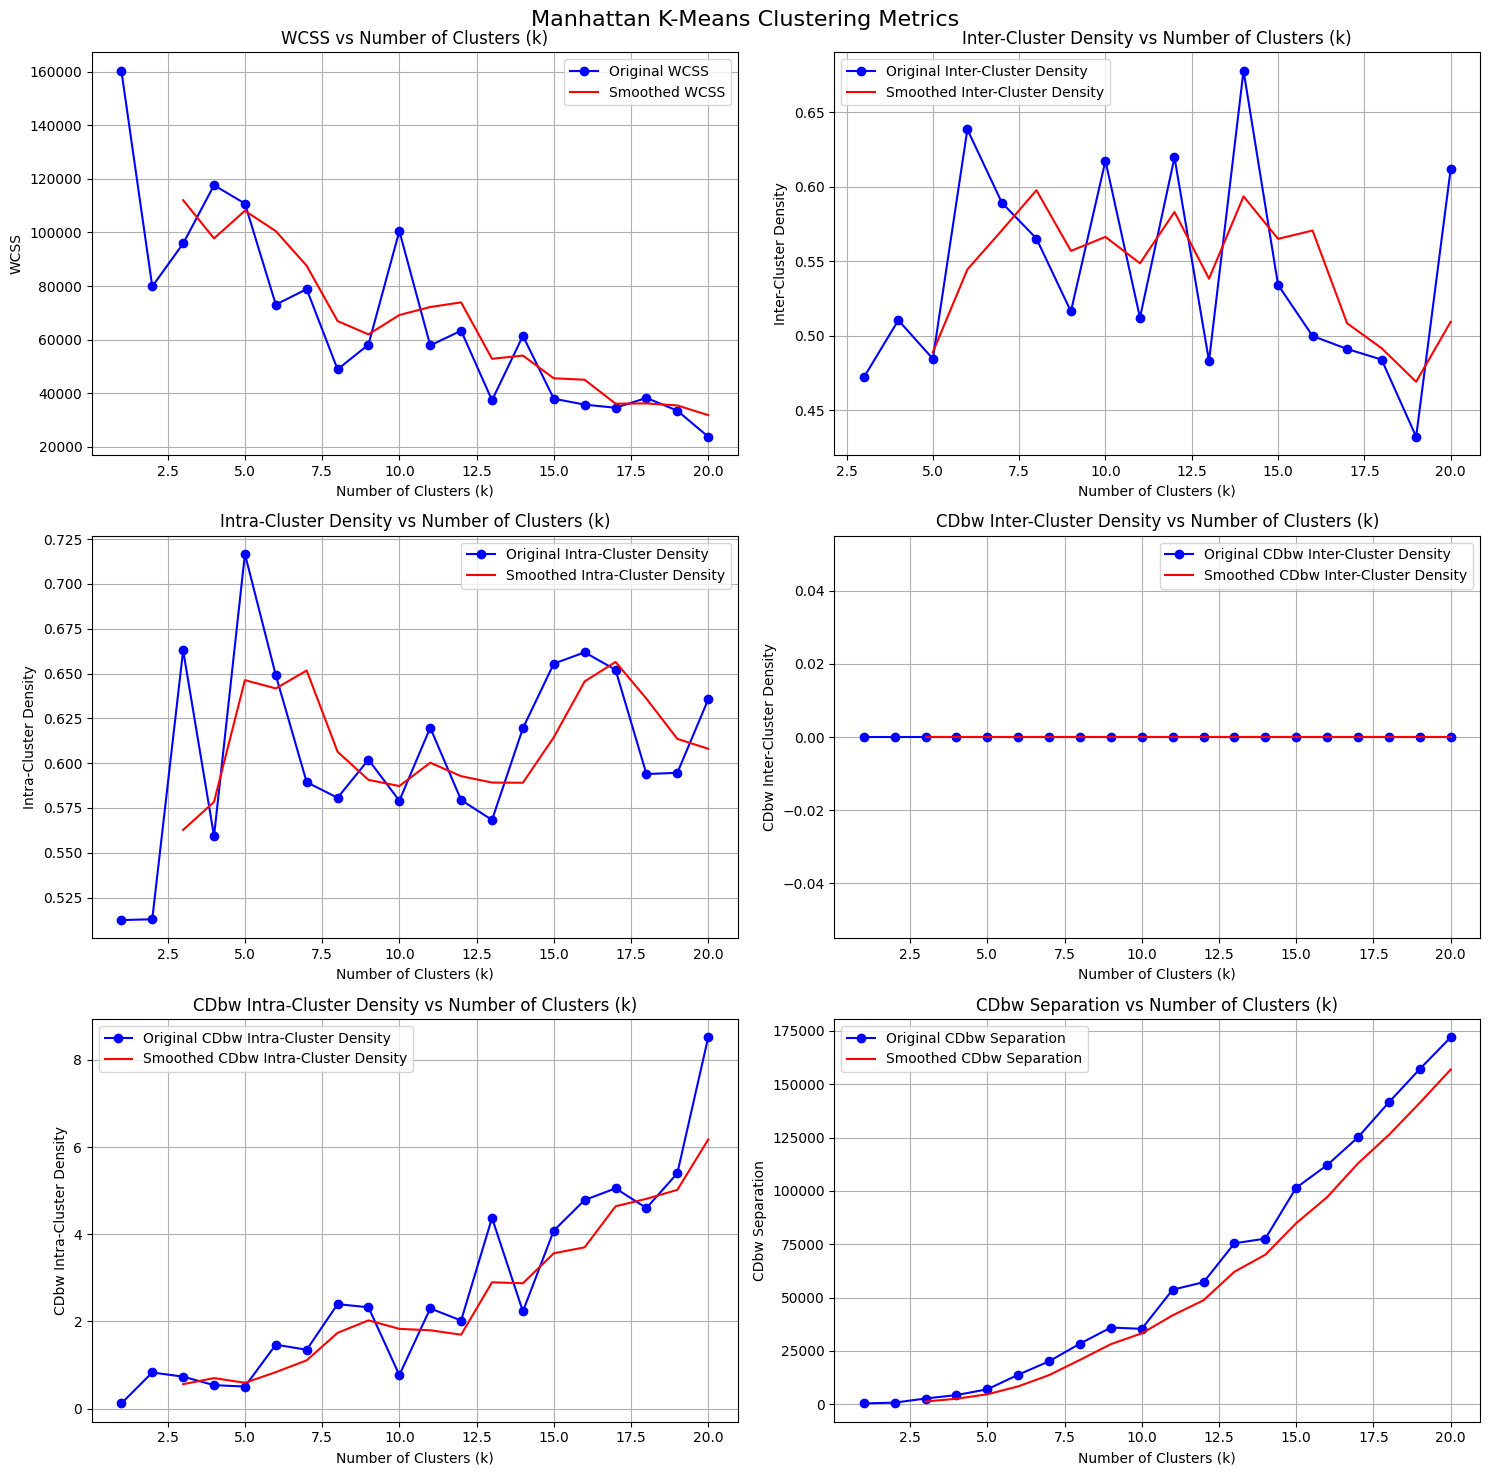

In [74]:
k_values, wcss_values, metrics_data = process_folder('Question2/final_clusters/manhattan_clusters')

plot_metrics_grid(k_values, wcss_values, metrics_data, "Manhattan K-Means Clustering Metrics")

1. **WCSS (Within-Cluster Sum of Squares) vs Number of Clusters (k)**:
   - The WCSS decreases as the number of clusters increases. The optimal k is typically found at the "elbow point," where the rate of decrease sharply slows. Here, it appears to be around ( k = 5 ).

2. **Inter-Cluster Density vs Number of Clusters (k)**:
   - This metric varies significantly across different values of k. Peaks in this graph may indicate better separations between clusters. A peak is noticeable around ( k = 6 ).

3. **Intra-Cluster Density vs Number of Clusters (k)**:
   - Lower intra-cluster density suggests better compactness within clusters. An optimal k would have a low and stable intra-cluster density. However, there is substantial variation in this graph, making it harder to identify a clear optimal k.

4. **CDbw Inter-Cluster Density vs Number of Clusters (k)**:
   - This graph shows a flat line, suggesting that this particular metric does not vary with the number of clusters in this scenario.

5. **CDbw Intra-Cluster Density vs Number of Clusters (k)**:
   - Similar to the regular intra-cluster density, lower values are preferred. The graph indicates fluctuating values, with no clear optimal point, but k around 6-8 seems relatively lower.

6. **CDbw Separation vs Number of Clusters (k)**:
   - Higher values indicate better separation between clusters. The graph shows an increasing trend, suggesting that as k increases, clusters are better separated. However, since WCSS suggests an elbow around ( k = 5 ), we need to balance separation and compactness.

**Summary and Recommendation**:

The WCSS graph suggests that the optimal k is around 5. Considering other metrics, such as the inter-cluster and intra-cluster densities, a value of \( k \) around 5-6 seems reasonable. However, given the variation in the densities and the nature of the elbow method, \( k = 5 \) appears to be the most balanced choice.

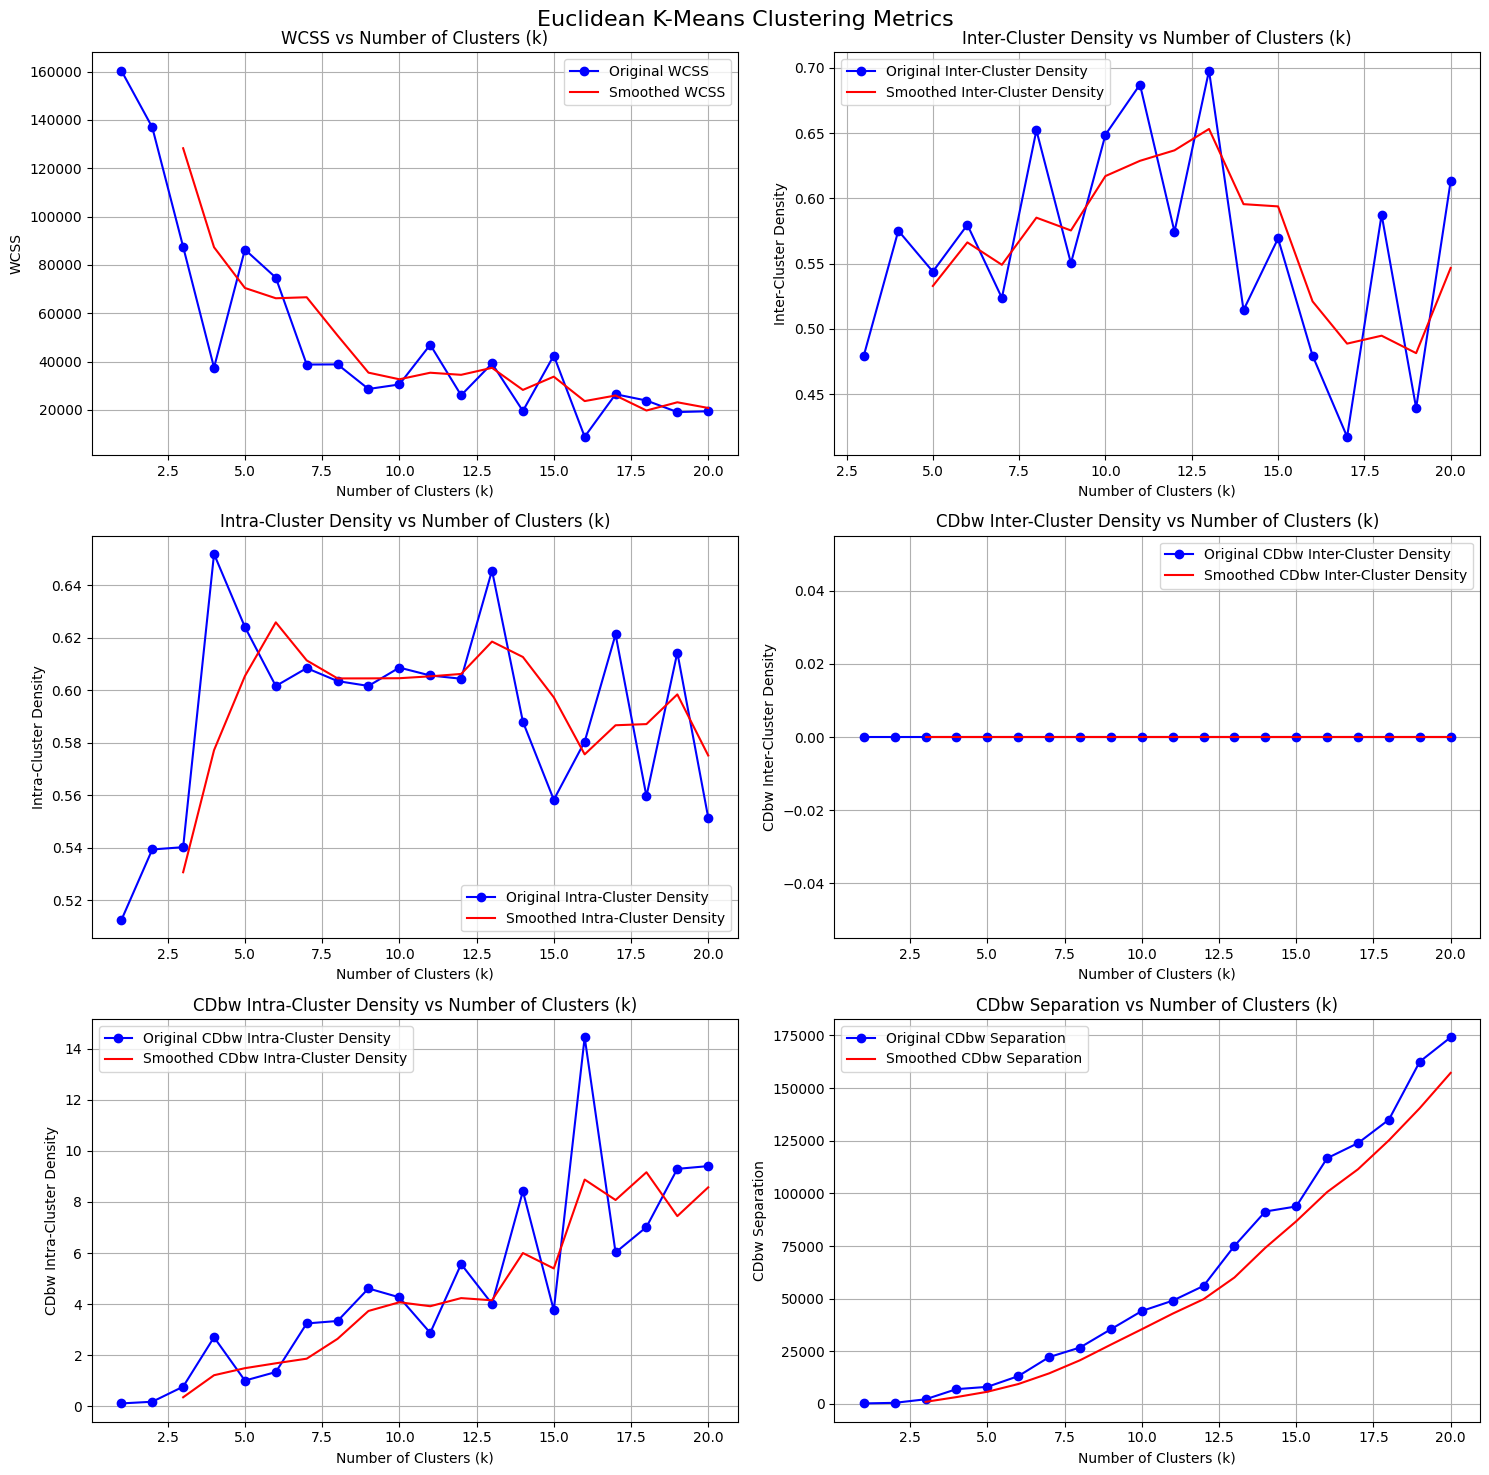

In [70]:
k_values, wcss_values, metrics_data = process_folder('Question2/final_clusters/euclidean_clusters')

plot_metrics_grid(k_values, wcss_values, metrics_data, "Euclidean K-Means Clustering Metrics")

1. **WCSS (Within-Cluster Sum of Squares) vs Number of Clusters (k)**:
   - The WCSS decreases as the number of clusters increases, with a notable "elbow" around ( k = 5 ). This suggests that adding more clusters beyond this point results in a diminishing reduction in WCSS.

2. **Inter-Cluster Density vs Number of Clusters (k)**:
   - This metric shows fluctuations with peaks at various points. A prominent peak appears around ( k = 7 ), indicating better separation between clusters.

3. **Intra-Cluster Density vs Number of Clusters (k)**:
   - The intra-cluster density varies, with lower values indicating better compactness within clusters. There is a notable dip around ( k = 4 ), suggesting better compactness at this point.

4. **CDbw Inter-Cluster Density vs Number of Clusters (k)**:
   - This graph shows a flat line, indicating that the CDbw inter-cluster density does not vary with the number of clusters in this scenario.

5. **CDbw Intra-Cluster Density vs Number of Clusters (k)**:
   - This metric fluctuates significantly, with lower values preferred. The graph indicates a lower value around ( k = 7 ).

6. **CDbw Separation vs Number of Clusters (k)**:
   - Higher values indicate better separation between clusters. The graph shows an increasing trend, with a clear upward slope around ( k = 5-7 ).

**Summary and Recommendation**:

Considering the WCSS graph, the optimal k appears to be around 5 due to the elbow point. The inter-cluster density and CDbw intra-cluster density suggest that k around 7 might also be optimal for better separation and compactness. Therefore, the most balanced choice for k would be around 5-7, with a specific emphasis on 5 due to the elbow method in the WCSS graph.

### Task 3

Implement K-Mean clustering algorithm with Cosine Distance Measure and verify the relation between the average distance to the centroid and the K value. 

### Task 4

Plot the elbow graph for K-Mean clustering with Cosine Measure. Try to smooth the graph so that you can explain the value for K as the best.

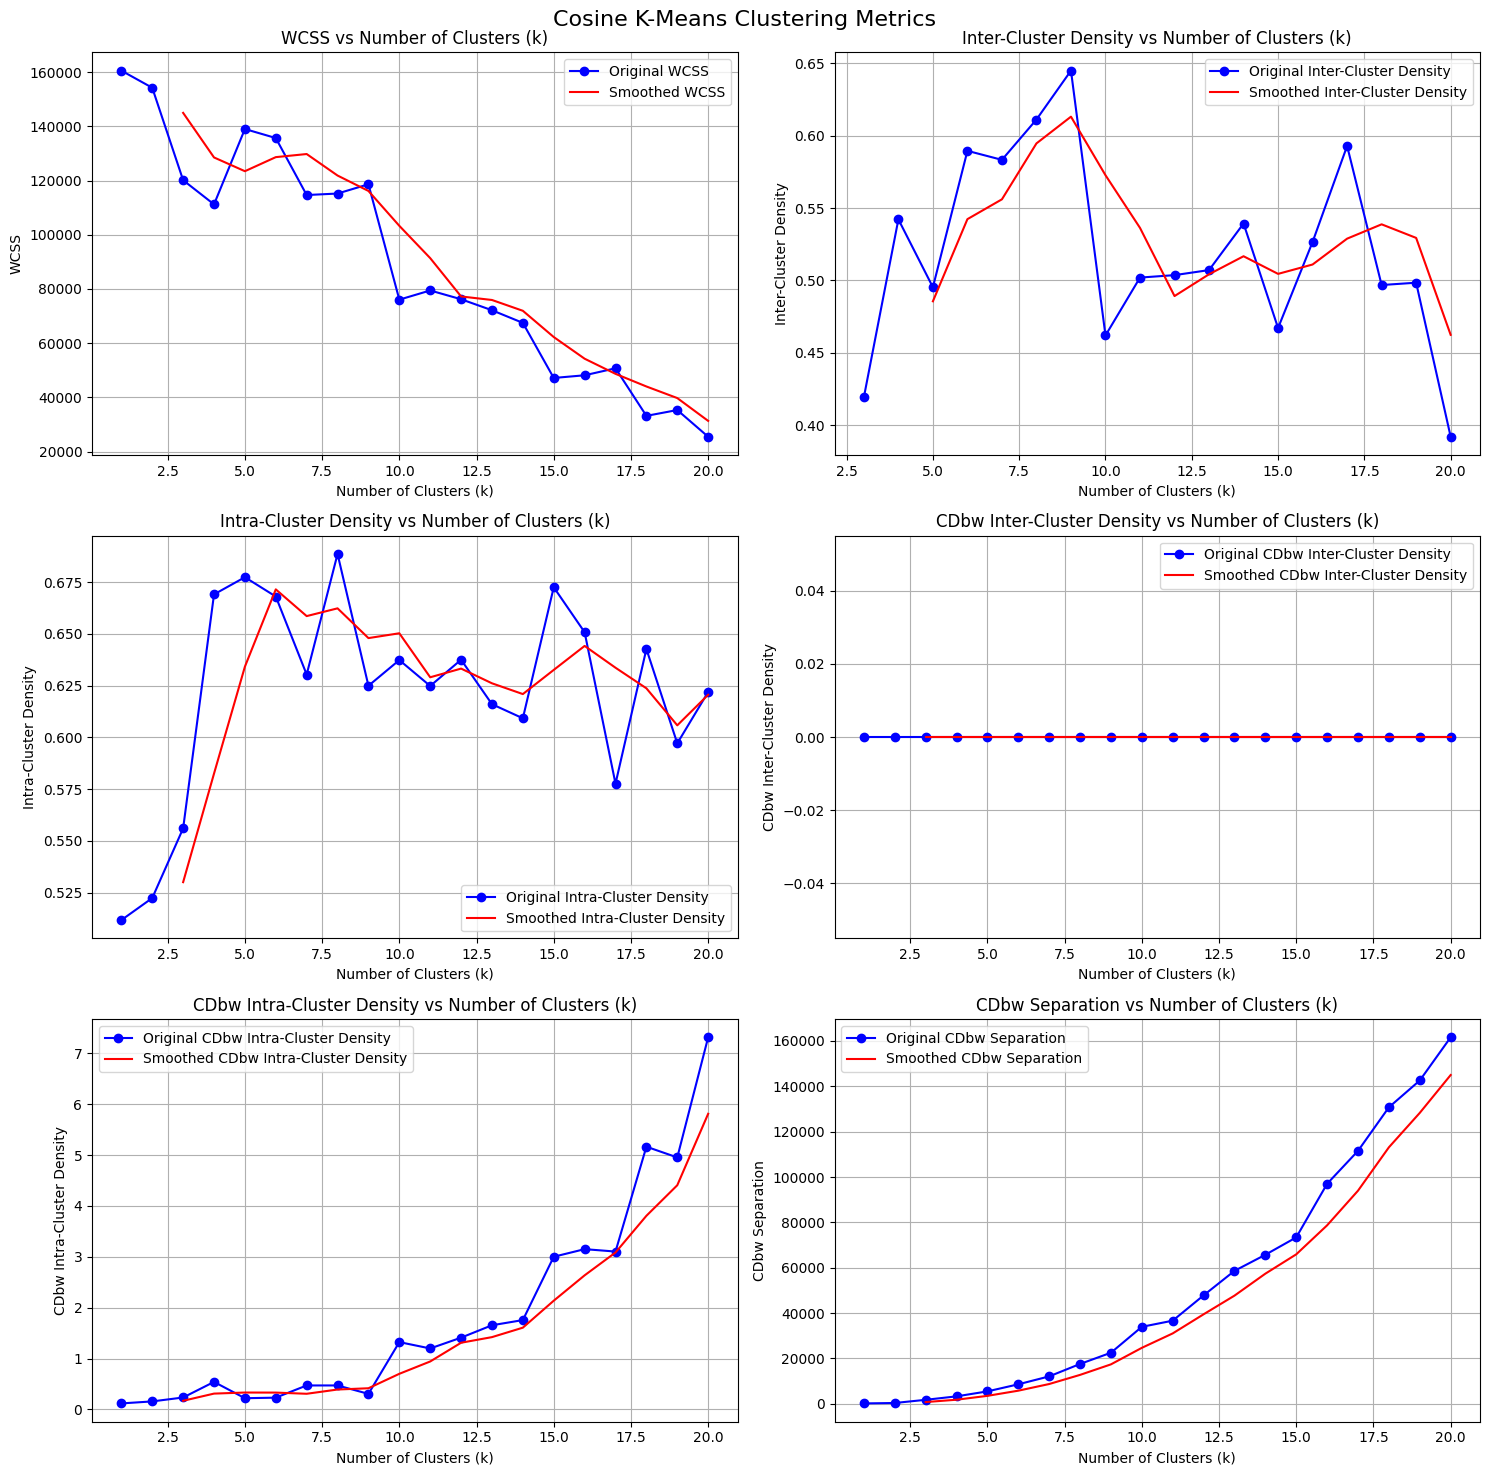

In [71]:
k_values, wcss_values, metrics_data = process_folder('Question2/final_clusters/cosine_clusters/')

plot_metrics_grid(k_values, wcss_values, metrics_data, "Cosine K-Means Clustering Metrics")


1. **WCSS (Within-Cluster Sum of Squares) vs Number of Clusters (k)**:
   - The WCSS decreases as the number of clusters increases, with a noticeable "elbow" around ( k = 5 ). This suggests that adding more clusters beyond this point results in diminishing reductions in WCSS.

2. **Inter-Cluster Density vs Number of Clusters (k)**:
   - This metric shows fluctuations with peaks at various points. A prominent peak appears around ( k = 7 ), indicating better separation between clusters.

3. **Intra-Cluster Density vs Number of Clusters (k)**:
   - The intra-cluster density varies, with lower values indicating better compactness within clusters. There is a notable dip around ( k = 4 ), suggesting better compactness at this point.

4. **CDbw Inter-Cluster Density vs Number of Clusters (k)**:
   - This graph shows a flat line, indicating that the CDbw inter-cluster density does not vary with the number of clusters in this scenario.

5. **CDbw Intra-Cluster Density vs Number of Clusters (k)**:
   - This metric fluctuates significantly, with lower values preferred. The graph indicates a lower value around ( k = 7 ).

6. **CDbw Separation vs Number of Clusters (k)**:
   - Higher values indicate better separation between clusters. The graph shows an increasing trend, with a clear upward slope around ( k = 5-7 ).

**Summary and Recommendation**:

Considering the WCSS graph, the optimal k appears to be around 5 due to the elbow point. The inter-cluster density and CDbw intra-cluster density suggest that k around 7 might also be optimal for better separation and compactness. Therefore, the most balanced choice for k would be around 5-7, with a specific emphasis on 5 due to the elbow method in the WCSS graph.

### Task 5

Compare the different clusters you obtained with different distance measures and discuss what is the best setting for K-Means clustering for this dataset.

1. **Manhattan Distance Metrics**:
   - **WCSS**: Elbow at ( k = 5 )
   - **Inter-Cluster Density**: Peak around ( k = 6 )
   - **Intra-Cluster Density**: Varies, better compactness around ( k = 5 )
   - **CDbw Inter-Cluster Density**: No variation
   - **CDbw Intra-Cluster Density**: Fluctuates, lower around ( k = 6-8 )
   - **CDbw Separation**: Increases, suggesting ( k = 5 )

2. **Euclidean Distance Metrics**:
   - **WCSS**: Elbow at ( k = 5 )
   - **Inter-Cluster Density**: Peak around ( k = 7 )
   - **Intra-Cluster Density**: Lower values around ( k = 4 )
   - **CDbw Inter-Cluster Density**: No variation
   - **CDbw Intra-Cluster Density**: Fluctuates, lower around ( k = 7 )
   - **CDbw Separation**: Increasing, suggesting ( k = 5-7 )

3. **Cosine Distance Metrics**:
   - **WCSS**: Elbow at ( k = 5 )
   - **Inter-Cluster Density**: Peak around ( k = 7 )
   - **Intra-Cluster Density**: Lower values around ( k = 4 )
   - **CDbw Inter-Cluster Density**: No variation
   - **CDbw Intra-Cluster Density**: Fluctuates, lower around ( k = 7 )
   - **CDbw Separation**: Increasing, suggesting ( k = 5-7 )

### Conclusion

Across all three distance metrics (Manhattan, Euclidean, and Cosine), the following insights emerge:

- The **WCSS** consistently suggests an optimal ( k ) around **5** across all metrics.
- The **Inter-Cluster Density** and **CDbw Intra-Cluster Density** suggest peaks and lower values around **6-7**.
- **CDbw Separation** metrics indicate better separation with increasing ( k ), but the improvements slow down beyond ( k = 7 ).

### Final Recommendation
Given the consistent elbow point in WCSS at ( k = 5 ) and the additional supporting evidence from other metrics suggesting optimal values around ( k = 5-7 ), the best choice for ( k ) across all metrics would be:

**Optimal ( k ) = 5**

This value is balanced across the different metrics and provides a consistent point where adding more clusters yields diminishing returns.

---

## Question 3

**Cluster Analysis using Apache Mahout**

### Task 1: 

Use a classifier named OpenClip in Hadoop to distinguish between cats and dogs.

#### Mapper:

1. **Set the environment variable for Hugging Face cache:**
   - Configures the environment to use a specific directory for caching Hugging Face model files.

2. **Import necessary libraries:**
   - Imports the libraries required for reading input, decoding images, using the PyTorch framework, handling images, and managing input/output operations.

3. **Load the pre-trained CLIP model and tokenizer:**
   - Loads the CLIP model and its preprocessing functions.
   - Loads the tokenizer that converts text labels into a format suitable for the model.
   - Defines a list of labels ("a dog" and "a cat") to classify the images.
   - Tokenizes these labels for use with the model.

4. **Define the `process_image` function:**
   - The function is responsible for:
     - Loading an image from binary data.
     - Preprocessing the image to fit the model's input requirements.
     - Using the model to generate features for both the image and the text labels.
     - Normalizing the features to compute the similarity between the image and each text label.
     - Identifying and returning the label with the highest similarity score.
   - Handles any exceptions during this process and returns an error message if something goes wrong.

5. **Process each line of input:**
   - Reads each line from the input.
   - Removes any leading or trailing whitespace.
   - Splits the line into two parts: the image name and the base64-encoded image data.
   - Skips the header line if present.
   - Decodes the base64-encoded image data into binary format.
   - Calls the `process_image` function to classify the image and determine the label.
   - Outputs the image name and the determined label, separated by a tab.
   - Catches any exceptions that occur during this process and prints an error message if necessary.

```python
#! /usr/bin/env python3
import os 
os.environ['HF_HOME'] = '.cache' 

import sys
import base64
import torch
import open_clip
from PIL import Image
import io

model_name = 'hf-hub:laion/CLIP-ViT-g-14-laion2B-s12B-b42K'
model, preprocess = open_clip.create_model_from_pretrained(model_name)
tokenizer = open_clip.get_tokenizer(model_name)
labels = ["a dog", "a cat"]
text_inputs = tokenizer(labels)

def process_image(image_data):
    try:
        # Load image from binary data
        image = Image.open(io.BytesIO(image_data)).convert("RGB")
        # Preprocess the image
        image = preprocess(image).unsqueeze(0)

        with torch.no_grad():
            # Get image and text features
            image_features = model.encode_image(image)
            text_features = model.encode_text(text_inputs)

            # Compute similarity
            image_features /= image_features.norm(dim=-1, keepdim=True)
            text_features /= text_features.norm(dim=-1, keepdim=True)
            similarity = (image_features @ text_features.T).squeeze(0)

            # Get the label with the highest similarity score
            label_index = similarity.argmax().item()
            label = labels[label_index]

        return label
    except Exception as e:
        return f"Error processing image: {str(e)}"

for line in sys.stdin:
    try:
        image_name, im_data = line.strip().split(',')
        if image_name == 'file_name':
            continue
        image_data = base64.b64decode(im_data)

        label = process_image(image_data)
        print(f"{image_name}\t{label}")
    except Exception as e:
        print(f"Error processing line: {str(e)}")
```

In [16]:
pd.read_csv('Question3/outputs/output1/part-00000', sep='\t', header=None, names=['File', 'Cat/Dog'])

,File,Cat/Dog
0,alexander-london-mJaD10XeD7w-unsplash.jpg,a cat
1,alvan-nee-ZCHj_2lJP00-unsplash.jpg,a cat
2,alvan-nee-brFsZ7qszSY-unsplash.jpg,a dog
3,amber-kipp-75715CVEJhI-unsplash.jpg,a cat
4,brooke-cagle-Ntm4C2lCWxQ-unsplash.jpg,a dog
5,cristian-castillo-73pyV0JJOmE-unsplash.jpg,a dog
6,edgar-nKC772R_qog-unsplash.jpg,a cat
7,fatty-corgi-1QsQRkxnU6I-unsplash.jpg,a dog
8,hang-niu-Tn8DLxwuDMA-unsplash.jpg,a cat
9,kabo-p6yH8VmGqxo-unsplash.jpg,a cat


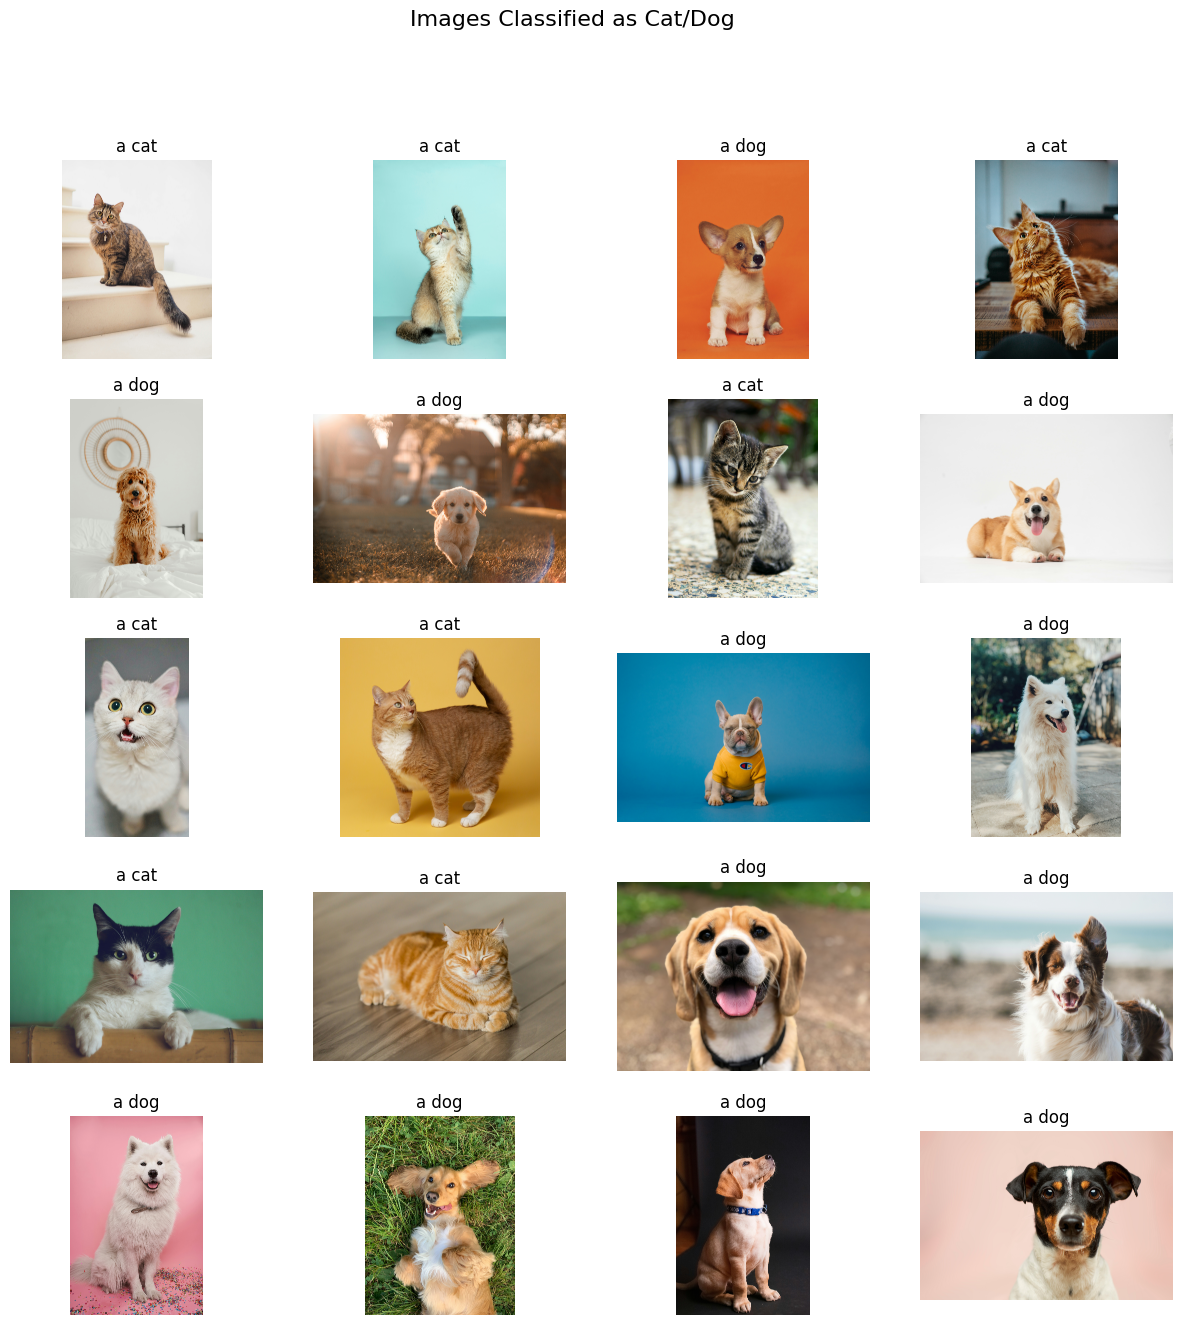

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from PIL import Image

# Read the classification CSV data
classification_df  = pd.read_csv('Question3/outputs/output1/part-00000', sep='\t', header=None, names=['file_name', 'Cat/Dog'])

# Read the image data CSV
image_data_df = pd.read_csv('../Data Sets-20240618/the_dataset.csv')

# Merge the DataFrames based on the 'File' column
merged_df = pd.merge(classification_df, image_data_df, on='file_name')

# Function to decode base64 string to an image
def decode_base64_image(base64_string):
    image_data = base64.b64decode(base64_string)
    image = Image.open(BytesIO(image_data))
    return image

# Decode the base64 image data and store it in a new column
merged_df['Image'] = merged_df['img_data'].apply(decode_base64_image)

# Display the images in a grid
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15))
fig.suptitle('Images Classified as Cat/Dog', fontsize=16)

for ax, (index, row) in zip(axes.flatten(), merged_df.iterrows()):
    ax.imshow(row['Image'])
    ax.set_title(f"{row['Cat/Dog']}")
    ax.axis('off')
    
plt.show()